# Introduction to Data Science Course - Final Project

#### Research Question:
Is it possible to predict whether the stock price will go up or down based on its annual financial report.


#### ML Area:
Classification

In [2]:
import os
import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


from sklearn.model_selection import train_test_split
# --------scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# --------cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# -------- classification
# *** Logistic Regression
from sklearn.linear_model import LogisticRegression
# *** KNN
from sklearn.neighbors import KNeighborsClassifier
# *** Decision Tree; Random Forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# *** Naive Bayes
from sklearn.naive_bayes import GaussianNB
# *** SVM classifier
from sklearn.svm import SVC
# --------  metrics:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer


import xgboost as xgb

In [3]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500Symbols = sorted(list(sp500['Symbol']))

sp400 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0]
sp400Symbols = sorted(list(sp400['Ticker symbol']))

sp600 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[1]
sp600Symbols = sorted(list(sp600['Ticker symbol']))

spSymbols = sp500Symbols + sp400Symbols + sp600Symbols

testSymbols = ['ABC']
currentDate = datetime.date.today()

# Data Collection

In [4]:
# Using Selenium to scrap the finnacial reports of each stock for "Seeking Alpha"
def get_financial_data(symbol):
    driver = webdriver.Chrome(executable_path="../chromedriver")
    driver.implicitly_wait(10)
    url = 'https://seekingalpha.com/symbol/' + symbol + '/income-statement'
    driver.get(url)

    # Getting a list of the dates
    dates_row = driver.find_element_by_class_name('dates-row')
    dates_list = dates_row.find_elements_by_tag_name("li")
    for i in range(len(dates_list)):
        dates_list[i] = dates_list[i].get_attribute('innerHTML')
    
    elem = driver.find_element_by_id('financials-tab')
    abs_html = elem.get_attribute('innerHTML')
    
    # Changing to YoY view
    view_arrow = driver.find_elements_by_class_name('select2-selection__arrow')[1]
    view_arrow.click()
    yoy_button = WebDriverWait(driver, 10).until(EC.presence_of_element_located(
        (By.XPATH, "//li[contains(text(),'YoY Growth')]")))
    yoy_button.click()
    
    elem = driver.find_element_by_id('financials-tab')
    yoy_html = elem.get_attribute('innerHTML')
    
    driver.quit()
    return (pd.read_html(abs_html), pd.read_html(yoy_html), dates_list)

# Cleaning the "incomce statement" column
def clean_income_statement(statement):
    if (statement[-30:] == "  Created with Highstock 6.1.4"):
        return statement[:len(statement) - 30]
    else:
        return statement

# Clean the whole data
def clean_data(df):
    df.replace('-',np.nan,inplace=True)
    df.dropna(how='all', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)
    df['Income Statement'] = df['Income Statement'].apply(clean_income_statement)
    df.set_index('Income Statement', inplace=True)
    df.dropna(how='all', inplace=True)
    return df[~df.index.duplicated(keep='last')]

In [ ]:
# Running the data scraper function on whole of the SP500 / SP400 / SP600 stocks
for symbol in sp400Symbols:
    abs_tables, yoy_tables, dates = get_financial_data(symbol)

    # Taking care of Absolute tables
    for table in abs_tables:
        table.columns = dates
        
    abs_df = pd.concat(abs_tables)
    
    abs_df = clean_data(abs_df)
    
    abs_df.to_csv(f'Stocks_Data\sp400\{symbol}_Absolute.csv')
    
    # Taking care of YoY tables
    for table in yoy_tables:
        table.columns = dates
        
    yoy_df = pd.concat(yoy_tables)

    yoy_df = clean_data(yoy_df)
    
    yoy_df.to_csv(f'Stocks_Data\sp400\{symbol}_YoY.csv')

# Data Processing

In [5]:
# Aggregating the Data Frames into one
def agg_df():
    yoy_agg_df = pd.DataFrame()
    abs_agg_df = pd.DataFrame()
    agg_errors = []

    for folder in os.listdir('Stocks_Data'):
        folder_path = os.path.join('Stocks_Data',folder)
        for file in os.listdir(folder_path):
            symbol, view = file.split('_')
            file_path = os.path.join(f'Stocks_Data\{folder}',file)
            next_df = pd.read_csv(file_path)
            next_df.set_index('Income Statement',inplace=True)
            next_df = next_df.T
            next_df['Symbol'] = [symbol for x in next_df.index]
            if view[:3] == 'YoY':
                try:
                    yoy_agg_df = pd.concat([yoy_agg_df, next_df.iloc[:-1]])
                except:
                    agg_errors.append(file)
                    continue
            else:
                try:
                    abs_agg_df = pd.concat([abs_agg_df, next_df.iloc[:-1]])
                except:
                    agg_errors.append(file)
                    continue
    
    abs_agg_df.index.name = 'Date'
    yoy_agg_df.index.name = 'Date'
    
    return abs_agg_df, yoy_agg_df, agg_errors

# Checking whether the stock price went up(1) or down / didn't changed(0)
def check_prices(df :pd.DataFrame):
    df[['Price Before', 'Price After','Change']] = np.nan
    df.index = pd.to_datetime(df.index)
    df.reset_index(inplace=True)
    
    prices_errors = []
    symbol = ""
    for index, row in df.iterrows():
        try:
            if symbol != row['Symbol']:
                print(row['Symbol'], end="\r")
                symbol = row['Symbol']
                start_date = row['Date']
                stock_data = web.DataReader(symbol, 'yahoo', start_date, currentDate)
                stock_data_avg = stock_data.groupby(pd.Grouper(freq='MS'))['Close'].mean() # Calculating the stock price mean on the month fo the financial report
            price_before = stock_data_avg.loc[row['Date']]
            df.loc[index, 'Price Before'] = price_before
            price_after = stock_data_avg.loc[row['Date'] + pd.DateOffset(months=1)] # Checking the price of the stock 1 month AFTER the finacial report
            df.loc[index, 'Price After'] = price_after
            if price_after > price_before * 1.01: # Checking whether the price went up by 1% atleast
                df.loc[index, 'Change'] = 1
            else:
                df.loc[index, 'Change'] = 0
        except:
            prices_errors.append(row['Symbol'])
            continue
            
    df.set_index('Date',inplace=True)
    return df, prices_errors

# Changing all the rows to numeric data
def cols_to_numeric(df :pd.DataFrame):
    for col in df.columns:
        if col == "Symbol":
            continue
        df.loc[:,col] = pd.to_numeric(df[col])
    return

Aggreagte all the data we collected into singular YoY DF and Absolute DF.

Save those aggregated DFs into files

In [ ]:
abs_agg_df, yoy_agg_df, agg_errors = agg_df()
yoy_agg_df, prices_errors = check_prices(yoy_agg_df)
yoy_agg_df = yoy_agg_df[~pd.isna(yoy_agg_df['Change'])] # Drop rows without any value in the "Change" column

abs_agg_df.to_csv('Absolute_Aggregate.csv')
yoy_agg_df.to_csv('YoY_Aggregate.csv')

In [ ]:
agg_errors # Checking that all the data got aggregated sussesfuly

In [ ]:
prices_errors # Checking which symbols got errors when trying to get their stock price

Loading the aggregated data that we saved

In [6]:
abs_agg_df = pd.read_csv('Absolute_Aggregate.csv')
abs_agg_df.set_index('Date',inplace=True)

yoy_agg_df = pd.read_csv('YoY_Aggregate.csv')
yoy_agg_df.set_index('Date',inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (8,15,24,38,40,41,56,62,68,76,82,83,88,93,94,102,103,106,123,129,131,134) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Cleaing Absoulte Aggregated Data Frame

In [7]:
abs_agg_df_filtered = abs_agg_df.dropna(axis = 1,thresh=2250) # Droping all the columns that doesn't have ATLEAST 2250 values

In [8]:
# Dealing with minus values, cutting off the bracekts and adding "-" sign
abs_agg_df_filtered.replace(r'\(\$?(\d*,?\d*\.?\d*)\)', r'-\1',regex=True, inplace=True)
# Cutting off '$', '%' and ',' signs
abs_agg_df_filtered.replace(r'\$|\%|\,', '',regex=True, inplace=True)
# Changing "NM" to "0"
abs_agg_df_filtered.replace(r'^NM$', '0',regex=True, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [9]:
cols_to_numeric(abs_agg_df_filtered)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [10]:
abs_agg_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4511 entries, Dec 2016 to Dec 2020
Data columns (total 38 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Total Revenues                          4509 non-null   float64
 1   Total Operating Expenses                4221 non-null   float64
 2   Operating Income                        4226 non-null   float64
 3   Net Interest Expenses                   3936 non-null   float64
 4   EBT, Excl. Unusual Items                4511 non-null   float64
 5   EBT, Incl. Unusual Items                4511 non-null   float64
 6   Income Tax Expense                      4412 non-null   float64
 7   Earnings From Continuing Operations     4511 non-null   float64
 8   Net Income to Company                   4511 non-null   float64
 9   Net Income                              4511 non-null   float64
 10  NI to Common Incl Extra Items           4226 non-null 

#### Cleaning YoY Aggregated Data Frame

In [11]:
yoy_agg_df_filtered = yoy_agg_df.dropna(axis = 1,thresh=3200) # Droping all the columns that doesn't have ATLEAST 3200 values

In [12]:
yoy_agg_df_filtered.replace(r'\$|\%|\,', '',regex=True, inplace=True)
yoy_agg_df_filtered.replace(r'\(\$?(\d*,?\d*\.?\d*)\)', r'-\1',regex=True, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [13]:
cols_to_numeric(yoy_agg_df_filtered)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [14]:
yoy_agg_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3568 entries, 2017-12-01 to 2020-12-01
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Total Revenues                          3565 non-null   float64
 1   Total Operating Expenses                3335 non-null   float64
 2   Operating Income                        3202 non-null   float64
 3   EBT, Excl. Unusual Items                3377 non-null   float64
 4   EBT, Incl. Unusual Items                3201 non-null   float64
 5   Revenue Per Share                       3563 non-null   float64
 6   Basic Weighted Average Shares Outst.    3566 non-null   float64
 7   Diluted Weighted Average Shares Outst.  3566 non-null   float64
 8   Normalized Basic EPS                    3368 non-null   float64
 9   Normalized Diluted EPS                  3368 non-null   float64
 10  EBITDA                                  3223 non-n

Preparing the final DF that we will perform ML on

In [15]:
final_yoy_agg_df = yoy_agg_df_filtered.dropna() # Dropping all the rows with missing values

In [16]:
final_yoy_agg_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2858 entries, 2017-12-01 to 2020-12-01
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Total Revenues                          2858 non-null   float64
 1   Total Operating Expenses                2858 non-null   float64
 2   Operating Income                        2858 non-null   float64
 3   EBT, Excl. Unusual Items                2858 non-null   float64
 4   EBT, Incl. Unusual Items                2858 non-null   float64
 5   Revenue Per Share                       2858 non-null   float64
 6   Basic Weighted Average Shares Outst.    2858 non-null   float64
 7   Diluted Weighted Average Shares Outst.  2858 non-null   float64
 8   Normalized Basic EPS                    2858 non-null   float64
 9   Normalized Diluted EPS                  2858 non-null   float64
 10  EBITDA                                  2858 non-n

In [17]:
final_yoy_agg_df

,Total Revenues,Total Operating Expenses,Operating Income,"EBT, Excl. Unusual Items","EBT, Incl. Unusual Items",Revenue Per Share,Basic Weighted Average Shares Outst.,Diluted Weighted Average Shares Outst.,Normalized Basic EPS,Normalized Diluted EPS,EBITDA,Normalized Net Income,Symbol,Price Before,Price After,Change
Date,,,,,,,,,,,,,,,,
2017-12-01,1.28,4.23,-8.80,-6.85,-30.13,-3.23,4.58,4.60,-9.67,-10.25,1.27,-6.23,ACC,42.088500,39.309524,0.0
2018-12-01,10.59,12.06,4.87,-22.06,70.94,9.30,1.24,1.26,-25.90,-24.59,9.10,-24.17,ACC,42.463684,43.227618,1.0
2019-12-01,7.07,4.98,15.78,18.46,-27.38,6.66,0.35,0.41,19.94,19.08,8.93,19.89,ACC,46.831904,46.125238,0.0
2020-12-01,-7.68,-2.04,-29.03,-69.96,-19.34,-7.90,0.21,0.31,-63.01,-63.31,-13.68,-63.11,ACC,42.595000,41.870000,0.0
2017-12-01,0.90,5.85,-1.63,-0.93,618.55,-0.55,1.46,1.27,-3.32,-2.95,0.11,-1.95,ACHC,32.072500,33.693334,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,-0.82,-4.22,-5.39,-5.91,-6.35,0.19,-1.02,-1.25,-4.99,-4.77,-7.56,-5.91,ZBRA,377.428181,401.101055,1.0
2017-12-01,8.57,1.18,19.40,21.80,24.19,9.86,-1.17,-1.02,23.13,23.07,15.91,21.75,ZTS,72.019499,75.964762,1.0
2018-12-01,9.76,12.96,8.18,8.92,10.82,11.34,-1.40,-1.27,10.48,10.72,10.63,9.10,ZTS,86.605790,84.647619,0.0


# EDA - Final YoY Aggregated DF

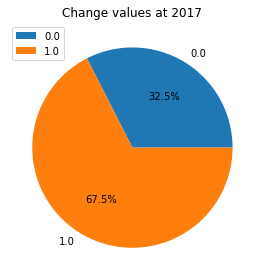

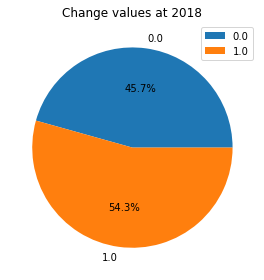

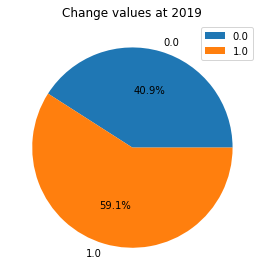

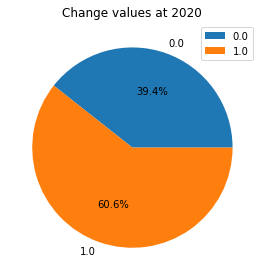

In [19]:
final_yoy_agg_df[final_yoy_agg_df.index <= '2017-12-31'].groupby('Change').count().plot.pie(y='Total Revenues', autopct='%1.1f%%')
plt.ylabel("")
plt.title("Change values at 2017")
plt.tight_layout()

final_yoy_agg_df[(final_yoy_agg_df.index > '2017-12-31') & (final_yoy_agg_df.index <= '2018-12-31')].groupby('Change').count().plot.pie(y='Total Revenues', autopct='%1.1f%%')
plt.ylabel("")
plt.title("Change values at 2018")
plt.tight_layout()

final_yoy_agg_df[(final_yoy_agg_df.index > '2018-12-31') & (final_yoy_agg_df.index <= '2019-12-31')].groupby('Change').count().plot.pie(y='Total Revenues', autopct='%1.1f%%')
plt.ylabel("")
plt.title("Change values at 2019")
plt.tight_layout()

final_yoy_agg_df[(final_yoy_agg_df.index > '2019-12-31') & (final_yoy_agg_df.index <= '2020-12-31')].groupby('Change').count().plot.pie(y='Total Revenues', autopct='%1.1f%%')
plt.ylabel("")
plt.title("Change values at 2020")
plt.tight_layout()

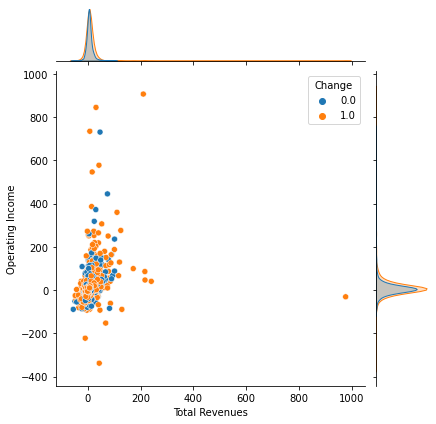

In [51]:
sns.jointplot(x='Total Revenues',y='Operating Income', hue='Change', data=final_yoy_agg_df,kind='scatter')

<AxesSubplot:>

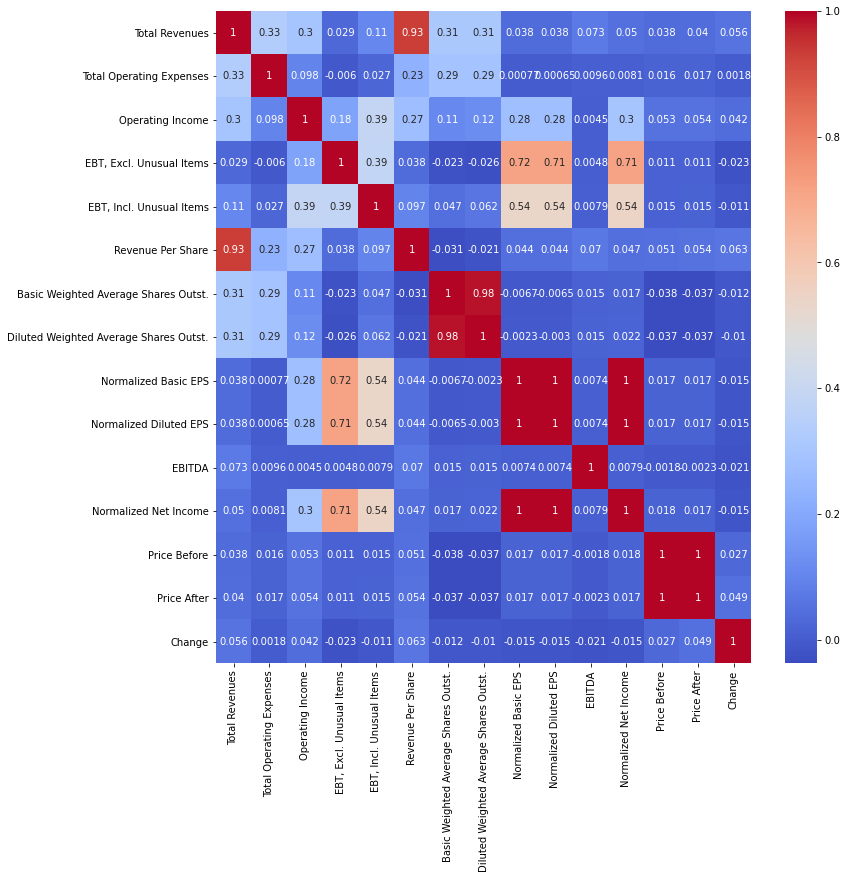

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(final_yoy_agg_df.corr(),cmap='coolwarm',annot=True, ax=ax)

# Machine Learning

In [15]:
def load_dataset(df :pd.DataFrame, label_column :str, non_relevant_cols :list):
    TRAINING_FEATURES = df.columns[df.columns != label_column]
    TARGET_FEATURE = label_column

    X = df[TRAINING_FEATURES]
    X.drop(non_relevant_cols, axis=1, inplace=True)
    y = df[TARGET_FEATURE]
    return X, y

In [16]:
X, y = load_dataset(final_yoy_agg_df, 'Change', ['Symbol', 'Price Before', 'Price After'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Random Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [18]:
X_train

,Total Revenues,Total Operating Expenses,Operating Income,"EBT, Excl. Unusual Items","EBT, Incl. Unusual Items",Revenue Per Share,Basic Weighted Average Shares Outst.,Diluted Weighted Average Shares Outst.,Normalized Basic EPS,Normalized Diluted EPS,EBITDA,Normalized Net Income
Date,,,,,,,,,,,,
2017-12-01,14.47,12.96,23.49,-10.56,-23.60,13.68,0.73,0.96,-13.81,-14.78,25.72,-13.51
2019-02-01,2.02,-25.50,-6.26,-4.82,23.36,12.25,-9.12,-9.23,4.78,4.87,-4.60,-4.82
2017-06-01,6.04,2.02,11.52,11.07,17.10,8.22,-2.01,-1.92,13.36,13.10,11.30,11.07
2017-12-01,5.44,-2.37,15.22,7.00,15.22,8.43,-2.76,-2.73,10.08,9.91,14.73,7.00
2018-12-01,3.22,-9.83,7.63,8.65,8.94,5.42,-2.11,-2.20,10.41,10.55,8.05,8.06
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-01,-0.44,15.63,-19.71,-18.40,-15.85,-0.56,0.12,-0.92,-18.60,-17.63,-11.90,-18.40
2019-12-01,-21.24,-41.24,-11.07,6.19,-48.09,-19.44,-2.22,-2.22,9.01,9.01,-2.64,6.19
2021-01-01,-13.41,-13.69,-86.92,-87.47,-98.53,-11.61,-2.02,-2.05,-87.22,-87.23,-63.37,-87.47


## Split by Date

In [19]:
new_X_train = X[X.index <= '2019-12-31']
new_X_test = X[X.index > '2019-12-31']
new_y_train = y[y.index <= '2019-12-31']
new_y_test = y[y.index > '2019-12-31']

In [20]:
new_X_train

,Total Revenues,Total Operating Expenses,Operating Income,"EBT, Excl. Unusual Items","EBT, Incl. Unusual Items",Revenue Per Share,Basic Weighted Average Shares Outst.,Diluted Weighted Average Shares Outst.,Normalized Basic EPS,Normalized Diluted EPS,EBITDA,Normalized Net Income
Date,,,,,,,,,,,,
2017-12-01,1.28,4.23,-8.80,-6.85,-30.13,-3.23,4.58,4.60,-9.67,-10.25,1.27,-6.23
2018-12-01,10.59,12.06,4.87,-22.06,70.94,9.30,1.24,1.26,-25.90,-24.59,9.10,-24.17
2019-12-01,7.07,4.98,15.78,18.46,-27.38,6.66,0.35,0.41,19.94,19.08,8.93,19.89
2017-12-01,0.90,5.85,-1.63,-0.93,618.55,-0.55,1.46,1.27,-3.32,-2.95,0.11,-1.95
2018-12-01,-32.85,-37.37,-30.22,-53.79,-71.54,-33.11,0.39,0.41,-54.32,-54.14,-33.57,-54.02
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-01,13.33,1.29,65.46,148.64,495.45,12.12,1.07,1.14,146.30,145.94,25.50,148.64
2019-12-01,6.33,2.76,12.77,14.44,14.12,5.54,0.75,0.54,13.58,13.75,10.04,14.44
2017-12-01,8.57,1.18,19.40,21.80,24.19,9.86,-1.17,-1.02,23.13,23.07,15.91,21.75


### Scalers

In [21]:
def scale_features(X_train, X_test, scale_type):
    X_train_scaled = pd.DataFrame()
    if scale_type == 'minmax':
        scaler = MinMaxScaler(feature_range=(-1, 1))
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.fit_transform(X_test)
    elif scale_type == 'standard':
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.fit_transform(X_test)
    return X_train_scaled, X_test_scaled

In [22]:
# Random split - scaling
X_train_minmax_scaled, X_test_minmax_scaled = scale_features(X_train, X_test, 'minmax')
X_train_standard_scaled, X_test_standard_scaled = scale_features(X_train, X_test, 'standard')

# Split by date - scaling
new_X_train_minmax_scaled, new_X_test_minmax_scaled = scale_features(new_X_train, new_X_test, 'minmax')
new_X_train_standard_scaled, new_X_test_standard_scaled = scale_features(new_X_train, new_X_test, 'standard')

## Classification Models

### Logistic Regression

#### without scaling

In [63]:
# Random split - test
LR_classification_model = LogisticRegression().fit(X_train, y_train)
y_pred = LR_classification_model.predict(X_test)

# Split by date - test
LR_classification_model = LogisticRegression().fit(new_X_train, new_y_train)
new_y_pred = LR_classification_model.predict(new_X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [64]:
# Random split - result
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.31      0.02      0.04       215
         1.0       0.62      0.97      0.76       357

    accuracy                           0.61       572
   macro avg       0.47      0.50      0.40       572
weighted avg       0.51      0.61      0.49       572

[[  5 210]
 [ 11 346]]


In [65]:
# Split by date - result
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

              precision    recall  f1-score   support

         0.0       0.32      0.15      0.20       278
         1.0       0.58      0.79      0.67       416

    accuracy                           0.53       694
   macro avg       0.45      0.47      0.44       694
weighted avg       0.48      0.53      0.48       694

[[ 41 237]
 [ 86 330]]


#### mimax scaling

In [66]:
# Random split - test
LR_classification_minmax_model = LogisticRegression().fit(X_train_minmax_scaled, y_train)
y_pred = LR_classification_minmax_model.predict(X_test_minmax_scaled)

# Split by date - test
LR_classification_minmax_model = LogisticRegression().fit(new_X_train_minmax_scaled, new_y_train)
new_y_pred = LR_classification_minmax_model.predict(new_X_test_minmax_scaled)

In [67]:
# Random split - result
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       215
         1.0       0.62      0.99      0.76       357

    accuracy                           0.62       572
   macro avg       0.31      0.50      0.38       572
weighted avg       0.39      0.62      0.48       572

[[  0 215]
 [  3 354]]


In [68]:
# Split by date - result
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

              precision    recall  f1-score   support

         0.0       0.31      0.02      0.03       278
         1.0       0.60      0.97      0.74       416

    accuracy                           0.59       694
   macro avg       0.45      0.50      0.39       694
weighted avg       0.48      0.59      0.46       694

[[  5 273]
 [ 11 405]]


#### standard scaling

In [69]:
# Random split - test
LR_classification_standard_model = LogisticRegression().fit(X_train_standard_scaled, y_train)
y_pred = LR_classification_standard_model.predict(X_test_standard_scaled)

# Split by date - test
LR_classification_standard_model = LogisticRegression().fit(new_X_train_standard_scaled, new_y_train)
new_y_pred = LR_classification_standard_model.predict(new_X_test_standard_scaled)

In [70]:
# Random split - result
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.24      0.03      0.06       215
         1.0       0.62      0.94      0.74       357

    accuracy                           0.60       572
   macro avg       0.43      0.49      0.40       572
weighted avg       0.48      0.60      0.49       572

[[  7 208]
 [ 22 335]]


In [71]:
# Split by date - result
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

              precision    recall  f1-score   support

         0.0       0.32      0.07      0.11       278
         1.0       0.59      0.90      0.71       416

    accuracy                           0.57       694
   macro avg       0.45      0.48      0.41       694
weighted avg       0.48      0.57      0.47       694

[[ 19 259]
 [ 41 375]]


### K-Nearest Neighbors

In [72]:
def find_best_k_for_KNN(X_train, y_train):
    parameters = {'n_neighbors':range(3,16,2)}
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters,scoring=metrics.make_scorer(metrics.precision_score))
    clf.fit(X_train, y_train)
    
    best_K = clf.best_params_['n_neighbors']
    
    return clf, best_K

#### without scaling

In [73]:
# Random split - test
KNN_classification_model, best_K = find_best_k_for_KNN(X_train, y_train)
y_pred = KNN_classification_model.predict(X_test)

# Split by date - test
KNN_classification_model, new_best_K = find_best_k_for_KNN(new_X_train, new_y_train)
new_y_pred = KNN_classification_model.predict(new_X_test)

In [74]:
# Random split - result
print("best K is:",best_K)
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

best K is: 9
              precision    recall  f1-score   support

         0.0       0.42      0.37      0.40       215
         1.0       0.65      0.69      0.67       357

    accuracy                           0.57       572
   macro avg       0.53      0.53      0.53       572
weighted avg       0.56      0.57      0.57       572

[[ 80 135]
 [110 247]]


In [75]:
# Split by date - result
print("best K is:",new_best_K)
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

best K is: 11
              precision    recall  f1-score   support

         0.0       0.40      0.32      0.36       278
         1.0       0.60      0.68      0.64       416

    accuracy                           0.54       694
   macro avg       0.50      0.50      0.50       694
weighted avg       0.52      0.54      0.53       694

[[ 89 189]
 [132 284]]


#### mimax scaling

In [76]:
# Random split - test
KNN_classification_minmax_model, best_K = find_best_k_for_KNN(X_train_minmax_scaled, y_train)
y_pred = KNN_classification_minmax_model.predict(X_test_minmax_scaled)

# Split by date - test
KNN_classification_model, new_best_K = find_best_k_for_KNN(new_X_train_minmax_scaled, new_y_train)
new_y_pred = KNN_classification_model.predict(new_X_test_minmax_scaled)

In [77]:
# Random split - result
print("best K is:",best_K)
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

best K is: 13
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       215
         1.0       0.62      0.99      0.76       357

    accuracy                           0.62       572
   macro avg       0.31      0.49      0.38       572
weighted avg       0.39      0.62      0.48       572

[[  0 215]
 [  4 353]]


In [78]:
# Split by date - result
print("best K is:",new_best_K)
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

best K is: 13
              precision    recall  f1-score   support

         0.0       0.29      0.01      0.01       278
         1.0       0.60      0.99      0.75       416

    accuracy                           0.60       694
   macro avg       0.44      0.50      0.38       694
weighted avg       0.47      0.60      0.45       694

[[  2 276]
 [  5 411]]


#### standard scaling

In [79]:
# Random split - test
KNN_classification_standard_model, best_K = find_best_k_for_KNN(X_train_standard_scaled, y_train)
y_pred = KNN_classification_standard_model.predict(X_test_standard_scaled)

# Split by date - test
KNN_classification_model, new_best_K = find_best_k_for_KNN(new_X_train_standard_scaled, new_y_train)
new_y_pred = KNN_classification_model.predict(new_X_test_standard_scaled)

In [80]:
# Random split - result
print("best K is:",best_K)
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

best K is: 15
              precision    recall  f1-score   support

         0.0       0.48      0.23      0.31       215
         1.0       0.65      0.85      0.74       357

    accuracy                           0.62       572
   macro avg       0.56      0.54      0.52       572
weighted avg       0.58      0.62      0.58       572

[[ 49 166]
 [ 53 304]]


In [81]:
# Split by date - result
print("best K is:",new_best_K)
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

best K is: 9
              precision    recall  f1-score   support

         0.0       0.42      0.25      0.31       278
         1.0       0.60      0.77      0.68       416

    accuracy                           0.56       694
   macro avg       0.51      0.51      0.49       694
weighted avg       0.53      0.56      0.53       694

[[ 69 209]
 [ 97 319]]


### Decision Tree

In [82]:
def find_best_decision_tree_params(X_train, y_train):
    parameters = {'max_depth':range(2,11), 'min_samples_split':range(5,21)}
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters,scoring=metrics.make_scorer(metrics.precision_score))
    clf.fit(X_train, y_train)
    
    best_max_depth = clf.best_params_['max_depth']
    best_min_samples_split = clf.best_params_['min_samples_split']
    
    return clf, best_max_depth, best_min_samples_split

#### without scaling

In [83]:
# Random split - test
DT_classification_model, best_max_depth, best_min_samples_split = find_best_decision_tree_params(X_train, y_train)
y_pred = DT_classification_model.predict(X_test)

# Split by date - test
DT_classification_model, new_best_max_depth, new_best_min_samples_split = find_best_decision_tree_params(new_X_train, new_y_train)
new_y_pred = DT_classification_model.predict(new_X_test)

In [84]:
# Random split - result
print("best max depth is:",best_max_depth)
print("best min samples split is:",best_min_samples_split)
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

best max depth is: 8
best min samples split is: 15
              precision    recall  f1-score   support

         0.0       0.43      0.38      0.40       215
         1.0       0.65      0.70      0.67       357

    accuracy                           0.58       572
   macro avg       0.54      0.54      0.54       572
weighted avg       0.57      0.58      0.57       572

[[ 81 134]
 [108 249]]


In [85]:
# Split by date - result
print("best max depth is:",new_best_max_depth)
print("best min samples split is:",new_best_min_samples_split)
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

best max depth is: 10
best min samples split is: 20
              precision    recall  f1-score   support

         0.0       0.44      0.39      0.41       278
         1.0       0.62      0.67      0.65       416

    accuracy                           0.56       694
   macro avg       0.53      0.53      0.53       694
weighted avg       0.55      0.56      0.55       694

[[108 170]
 [136 280]]


#### mimax scaling

In [86]:
# Random split - test
DT_classification_minmax_model, best_max_depth, best_min_samples_split = find_best_decision_tree_params(X_train_minmax_scaled, y_train)
y_pred = DT_classification_minmax_model.predict(X_test_minmax_scaled)

# Split by date - test
DT_classification_minmax_model, new_best_max_depth, best_min_samples_split = find_best_decision_tree_params(new_X_train_minmax_scaled, new_y_train)
new_y_pred = DT_classification_minmax_model.predict(new_X_test_minmax_scaled)

In [87]:
# Random split - result
print("best max depth is:",best_max_depth)
print("best min samples split is:",best_min_samples_split)
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

best max depth is: 8
best min samples split is: 13
              precision    recall  f1-score   support

         0.0       0.33      0.00      0.01       215
         1.0       0.62      0.99      0.77       357

    accuracy                           0.62       572
   macro avg       0.48      0.50      0.39       572
weighted avg       0.51      0.62      0.48       572

[[  1 214]
 [  2 355]]


In [88]:
# Split by date - result
print("best max depth is:",new_best_max_depth)
print("best min samples split is:",new_best_min_samples_split)
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

best max depth is: 5
best min samples split is: 20
              precision    recall  f1-score   support

         0.0       0.40      1.00      0.57       278
         1.0       0.67      0.00      0.01       416

    accuracy                           0.40       694
   macro avg       0.53      0.50      0.29       694
weighted avg       0.56      0.40      0.23       694

[[277   1]
 [414   2]]


#### standard scaling

In [89]:
# Random split - test
DT_classification_standard_model, best_max_depth, best_min_samples_split = find_best_decision_tree_params(X_train_standard_scaled, y_train)
y_pred = DT_classification_standard_model.predict(X_test_standard_scaled)

# Split by date - test
DT_classification_standard_model, new_best_max_depth, best_min_samples_split = find_best_decision_tree_params(new_X_train_standard_scaled, new_y_train)
new_y_pred = DT_classification_standard_model.predict(new_X_test_standard_scaled)

In [90]:
# Random split - result
print("best max depth is:",best_max_depth)
print("best min samples split is:",best_min_samples_split)
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

best max depth is: 8
best min samples split is: 20
              precision    recall  f1-score   support

         0.0       0.42      0.23      0.30       215
         1.0       0.64      0.81      0.71       357

    accuracy                           0.59       572
   macro avg       0.53      0.52      0.50       572
weighted avg       0.56      0.59      0.56       572

[[ 49 166]
 [ 67 290]]


In [91]:
# Split by date - result
print("best max depth is:",new_best_max_depth)
print("best min samples split is:",new_best_min_samples_split)
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

best max depth is: 10
best min samples split is: 20
              precision    recall  f1-score   support

         0.0       0.38      0.32      0.35       278
         1.0       0.59      0.66      0.62       416

    accuracy                           0.52       694
   macro avg       0.49      0.49      0.49       694
weighted avg       0.51      0.52      0.51       694

[[ 89 189]
 [143 273]]


### Random Forest

In [92]:
def find_best_random_forest_params(X_train, y_train):
    parameters = {'n_estimators':range(50,551,100)}
    rf = RandomForestClassifier()
    clf = GridSearchCV(rf, parameters,scoring=metrics.make_scorer(metrics.precision_score))
    clf.fit(X_train, y_train)
    
    best_n_estimators = clf.best_params_['n_estimators']
    
    return clf, best_n_estimators

#### without scaling

In [93]:
# Random split - test
RF_classification_model, best_n_estimators = find_best_random_forest_params(X_train, y_train)
y_pred = RF_classification_model.predict(X_test)

# Split by date - test
RF_classification_model, new_best_n_estimators = find_best_random_forest_params(new_X_train, new_y_train)
new_y_pred = RF_classification_model.predict(new_X_test)

In [94]:
# Random split - result
print("best number of estimators is:",best_n_estimators)
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

best number of estimators is: 50
              precision    recall  f1-score   support

         0.0       0.43      0.37      0.40       215
         1.0       0.65      0.71      0.68       357

    accuracy                           0.58       572
   macro avg       0.54      0.54      0.54       572
weighted avg       0.57      0.58      0.57       572

[[ 80 135]
 [105 252]]


In [95]:
# Split by date - result
print("best number of estimators is:",new_best_n_estimators)
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

best number of estimators is: 450
              precision    recall  f1-score   support

         0.0       0.43      0.37      0.39       278
         1.0       0.61      0.67      0.64       416

    accuracy                           0.55       694
   macro avg       0.52      0.52      0.52       694
weighted avg       0.54      0.55      0.54       694

[[102 176]
 [137 279]]


#### mimax scaling

In [96]:
# Random split - test
RF_classification_minmax_model, best_n_estimators = find_best_random_forest_params(X_train_minmax_scaled, y_train)
y_pred = RF_classification_minmax_model.predict(X_test_minmax_scaled)

# Split by date - test
RF_classification_minmax_model, new_best_n_estimators = find_best_random_forest_params(new_X_train_minmax_scaled, new_y_train)
new_y_pred = RF_classification_minmax_model.predict(new_X_test_minmax_scaled)

In [97]:
# Random split - result
print("best number of estimators is:",best_n_estimators)
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

best number of estimators is: 350
              precision    recall  f1-score   support

         0.0       0.25      0.00      0.01       215
         1.0       0.62      0.99      0.77       357

    accuracy                           0.62       572
   macro avg       0.44      0.50      0.39       572
weighted avg       0.48      0.62      0.48       572

[[  1 214]
 [  3 354]]


In [98]:
# Split by date - result
print("best number of estimators is:",new_best_n_estimators)
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

best number of estimators is: 450
              precision    recall  f1-score   support

         0.0       0.40      1.00      0.57       278
         1.0       1.00      0.00      0.00       416

    accuracy                           0.40       694
   macro avg       0.70      0.50      0.29       694
weighted avg       0.76      0.40      0.23       694

[[278   0]
 [415   1]]


#### standard scaling

In [99]:
# Random split - test
RF_classification_standard_model, best_n_estimators = find_best_random_forest_params(X_train_standard_scaled, y_train)
y_pred = RF_classification_standard_model.predict(X_test_standard_scaled)

# Split by date - test
RF_classification_standard_model, new_best_n_estimators = find_best_random_forest_params(new_X_train_standard_scaled, new_y_train)
new_y_pred = RF_classification_standard_model.predict(new_X_test_standard_scaled)

In [100]:
# Random split - result
print("best number of estimators is:",best_n_estimators)
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

best number of estimators is: 450
              precision    recall  f1-score   support

         0.0       0.44      0.07      0.12       215
         1.0       0.63      0.95      0.76       357

    accuracy                           0.62       572
   macro avg       0.53      0.51      0.44       572
weighted avg       0.56      0.62      0.52       572

[[ 15 200]
 [ 19 338]]


In [101]:
# Split by date - result
print("best number of estimators is:",new_best_n_estimators)
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

best number of estimators is: 150
              precision    recall  f1-score   support

         0.0       0.41      0.24      0.31       278
         1.0       0.60      0.77      0.68       416

    accuracy                           0.56       694
   macro avg       0.51      0.51      0.49       694
weighted avg       0.53      0.56      0.53       694

[[ 68 210]
 [ 97 319]]


### Naive Bayes

#### without scaling

In [102]:
# Random split - test
NB_classification_model = GaussianNB().fit(X_train, y_train)
y_pred = NB_classification_model.predict(X_test)

# Split by date - test
NB_classification_model = GaussianNB().fit(new_X_train, new_y_train)
new_y_pred = NB_classification_model.predict(new_X_test)

In [103]:
# Random split - result
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.42      0.07      0.13       215
         1.0       0.63      0.94      0.75       357

    accuracy                           0.61       572
   macro avg       0.52      0.51      0.44       572
weighted avg       0.55      0.61      0.52       572

[[ 16 199]
 [ 22 335]]


In [104]:
# Split by date - result
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

              precision    recall  f1-score   support

         0.0       0.36      0.01      0.03       278
         1.0       0.60      0.98      0.74       416

    accuracy                           0.60       694
   macro avg       0.48      0.50      0.39       694
weighted avg       0.50      0.60      0.46       694

[[  4 274]
 [  7 409]]


#### mimax scaling

In [105]:
# Random split - test
NB_classification_minmax_model = GaussianNB().fit(X_train_minmax_scaled, y_train)
y_pred = NB_classification_minmax_model.predict(X_test_minmax_scaled)

# Split by date - test
NB_classification_minmax_model = GaussianNB().fit(new_X_train_minmax_scaled, new_y_train)
new_y_pred = NB_classification_minmax_model.predict(new_X_test_minmax_scaled)

In [106]:
# Random split - result
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.38      1.00      0.55       215
         1.0       0.50      0.00      0.01       357

    accuracy                           0.38       572
   macro avg       0.44      0.50      0.28       572
weighted avg       0.45      0.38      0.21       572

[[214   1]
 [356   1]]


In [107]:
# Split by date - result
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

              precision    recall  f1-score   support

         0.0       0.40      1.00      0.57       278
         1.0       0.00      0.00      0.00       416

    accuracy                           0.40       694
   macro avg       0.20      0.50      0.29       694
weighted avg       0.16      0.40      0.23       694

[[278   0]
 [416   0]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### standard scaling

In [108]:
# Random split - test
NB_classification_standard_model = GaussianNB().fit(X_train_standard_scaled, y_train)
y_pred = NB_classification_standard_model.predict(X_test_standard_scaled)

# Split by date - test
NB_classification_standard_model = GaussianNB().fit(new_X_train_standard_scaled, new_y_train)
new_y_pred = NB_classification_standard_model.predict(new_X_test_standard_scaled)

In [109]:
# Random split - result
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.38      0.91      0.53       215
         1.0       0.64      0.10      0.17       357

    accuracy                           0.40       572
   macro avg       0.51      0.50      0.35       572
weighted avg       0.54      0.40      0.31       572

[[195  20]
 [321  36]]


In [110]:
# Split by date - result
print(metrics.classification_report(new_y_test,new_y_pred))
print(metrics.confusion_matrix(new_y_test, new_y_pred))

              precision    recall  f1-score   support

         0.0       0.36      0.65      0.46       278
         1.0       0.48      0.21      0.30       416

    accuracy                           0.39       694
   macro avg       0.42      0.43      0.38       694
weighted avg       0.43      0.39      0.36       694

[[180  98]
 [327  89]]


# XGBoost Tests (WIP)

In [ ]:
xg_reg = xgb.XGBClassifier(verbosity = 0, booster = 'gbtree', objective = 'binary:logistic', min_child_weight = 2,
                           max_delta_step = 2 ,learning_rate = 0.9, n_estimators = 8, tree_method = 'hist',
                           max_depth = 7)
# dart
# gbtree
# gblinear

xg_reg.fit(X_train,y_train)

y_pred = xg_reg.predict(X_test)

print("accuracy is:",metrics.accuracy_score(y_test, y_pred))
print("precision is:",metrics.precision_score(y_test, y_pred))
print("recall is:",metrics.recall_score(y_test, y_pred))
print("f1 is:",metrics.f1_score(y_test, y_pred))
metrics.confusion_matrix(y_test, y_pred)

In [ ]:
print("accuracy is:",metrics.accuracy_score(y_test, y_pred))
print("precision is:",metrics.precision_score(y_test, y_pred))
print("recall is:",metrics.recall_score(y_test, y_pred))
print("f1 is:",metrics.f1_score(y_test, y_pred))
metrics.confusion_matrix(y_test, y_pred)

# xg_reg = xgb.XGBClassifier(verbosity = 0, booster = 'gbtree', objective = 'binary:logistic', min_child_weight = 1,
#                            max_delta_step = 0.4 ,learning_rate = 0.9, n_estimators = 9, tree_method = 'hist',
#                            max_depth = 6)
# accuracy is: 0.585
# precision is: 0.6745098039215687
# recall is: 0.6745098039215687
# f1 is: 0.6745098039215687
# array([[ 62,  83],
#        [ 83, 172]], dtype=int64)

In [ ]:
print("accuracy is:",metrics.accuracy_score(y_test, y_pred))
print("precision is:",metrics.precision_score(y_test, y_pred))
print("recall is:",metrics.recall_score(y_test, y_pred))
print("f1 is:",metrics.f1_score(y_test, y_pred))
metrics.confusion_matrix(y_test, y_pred)

# xg_reg = xgb.XGBClassifier(objective ='reg:pseudohubererror',min_child_weight = 1.1, max_delta_step = 1,
#                            n_estimators = 9)
# accuracy is: 0.6225
# precision is: 0.6573426573426573
# recall is: 0.7800829875518672
# f1 is: 0.713472485768501
# array([[ 61,  98],
#        [ 53, 188]], dtype=int64)

# xg_reg = xgb.XGBClassifier(objective ='reg:logistic',min_child_weight = 1.9, max_delta_step = 0.4, learning_rate = 0.9,
#                 n_estimators = 15, tree_method = 'hist', max_depth = 10)
# accuracy is: 0.625
# precision is: 0.6666666666666666
# recall is: 0.7551867219917012
# f1 is: 0.708171206225681
# array([[ 68,  91],
#        [ 59, 182]], dtype=int64)